# 视差法测量昴星团的距离

刘畅 1600012139

In [1]:
import numpy as np
from yt.units import *
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

## 地球轨道参数

Julian Date of Vernal Equinox at 2000: 2451623.815972

Julian Date of Perihelion at 2000 : 2451546.708333

Earth Orbital Period : 365.25 days

Earth Obliquity : 23.44 deg

Orbit eccentricity : 0.0167

首先，我们希望知道，给定时间 $T$，地球在黄道面上的位置，为此我们以黄道面为坐标平面，太阳为坐标原点，地球轨道的长轴为$x$轴，地球近日点处 $x=a(1-e)>0$，这里 $a=1$ AU 是轨道半长轴，$e=0.0167$ 是轨道离心率

In [2]:
a = AU
e = 0.0167

对于偏近点角 $\psi$，我们知道

$$
\psi-e\sin\psi=\frac{2\pi}{P} (T-T_P)
$$

这里的 $T_P$ 是地球过近日点的时刻，可以取为 $2451546.708333$ d，$P=365.25$ d 则是一个恒星年

In [3]:
TP = 2451546.708333 * day
P = 365.25 * day

虽然无法用 $T$ 解析地表示出 $\psi$，但原则上依然可以用简单的几何关系得到地球的坐标

$$
x=a(\cos\psi(T)-e),\quad y=a\sqrt{1-e^2}\sin\psi(T)
$$

如图

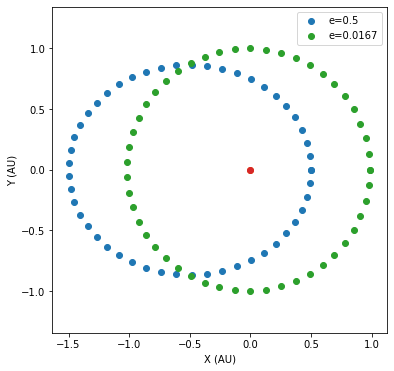

In [4]:
def psi_t(t, T0=0):
    theta = t * np.pi * 2 / P
    Psi = lambda psi: psi - e * np.sin(psi) - theta
    return fsolve(Psi, [theta])

def test_psi(e=0.0167):
    T_test = np.linspace(0, P, 50)
    psi = np.array([])
    for t in T_test:
        psi = np.append(psi, psi_t(t))
    X = a * (np.cos(psi) - e)
    Y = a * (np.sqrt(1 - e**2) * np.sin(psi))
    plt.scatter(X, Y, label='e={}'.format(e))
    plt.axis('equal')
    plt.scatter([0],[0])

plt.figure(figsize=(6,6))    
test_psi(e=0.5)
test_psi()
plt.xlabel('X (AU)')
plt.ylabel('Y (AU)')
plt.legend()
plt.show()

##  黄道坐标与赤道坐标的转化

In [5]:
from mpl_toolkits.mplot3d import Axes3D

由于黄赤交角 ($E=23.44$ deg) 的存在，赤道面和黄道面是不重合的。我们对恒星视差的测量在赤道坐标系中进行，因此，我们有必要将地球在黄道面上的位置转化为太阳在赤道坐标上的位置。

一个重要的参数是在黄道坐标系中，近日点处地球的方向与春分点处的夹角 $\Delta$ (春分点处的真近点角)。给定两者的时间差 $\Delta T$ 之后，首先可以计算出春分点处地球的坐标 $(x(\Delta T),y(\Delta T))$，从而求出对应的真近点角。

In [6]:
E = 23.44 * degree
TE = 2451623.815972 * day
DeltaT = TE - TP
xE = a * (np.cos(psi_t(DeltaT)) - e)
yE = a * (np.sqrt(1 - e**2) * np.sin(psi_t(DeltaT)))
Delta = np.arctan2(yE, xE)
print('Psi = {:.4f} radian'.format(float(Delta / np.pi * 180)))

Psi = 77.8652 radian


在进行黄道平面到赤道平面的转换之前，先将坐标原点由太阳变为地球，$x$ 轴依然为半长轴。为了保证地球位于近日点时太阳坐标 $x>0$，需要将原先的 $x$ 轴和 $y$ 轴反向，所以在这个新的坐标系中，$T_P+\Delta T$ 时刻太阳的坐标恰为 $(x(\Delta T),y(\Delta T))$。

从而可以将每个 $(x,y)$ 顺时针旋转 $\Delta$，得到同样在黄道平面上的以地球为原点，但以子午线为 $x$ 轴，春分点 $x'_E>0$ 的坐标系下的坐标 $(x',y')$

$$
x' = x\cos \Delta+y\sin\Delta,\quad y'=-x\sin\Delta+y\cos\Delta
$$

最后将 $(x',y',0)$ 绕 $x'$ 轴逆时针旋转 $E$，得到$T$ 时刻太阳在赤道坐标系中的位置 $(x_S,y_E,z_E)$

$$
x_E=x',\quad y_E=y'\cos E,\quad z_E=y'\sin E
$$

In [7]:
def xyzE_t(t, T0=0):
    theta = t * np.pi * 2 / P
    Psi = lambda psi: psi - e * np.sin(psi) - theta
    psi = fsolve(Psi, [theta])
    X = a * (np.cos(psi) - e)
    Y = a * (np.sqrt(1 - e**2) * np.sin(psi))
    XE = (X * np.cos(Delta) + Y * np.sin(Delta))
    YE = (-X * np.sin(Delta) + Y * np.cos(Delta)) * np.cos(E)
    ZE = (-X * np.sin(Delta) + Y * np.cos(Delta)) * np.sin(E)
    return (XE, YE, ZE)

In [8]:
T_test = np.linspace(0, P, 50)
XE, YE, ZE = xyzE_t(T_test, T0=TP)

Text(0.5, 0, 'Z (AU)')

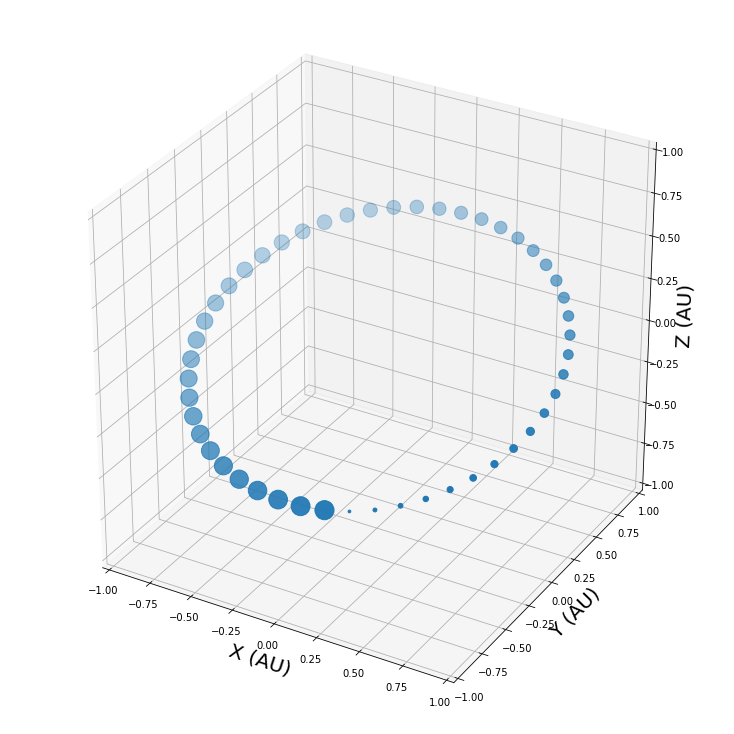

In [9]:
f, ax = plt.subplots(figsize=(10, 10))
ax = Axes3D(f)
ax.scatter3D(XE, YE, ZE, s=T_test/day)
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)

ax.set_xlabel('X (AU)', fontsize=20)
ax.set_ylabel('Y (AU)', fontsize=20)
ax.set_zlabel('Z (AU)', fontsize=20)

可以看到在一年之中太阳赤经赤纬的变化

Text(0.5, 0, 'Time since Perihelion (Day)')

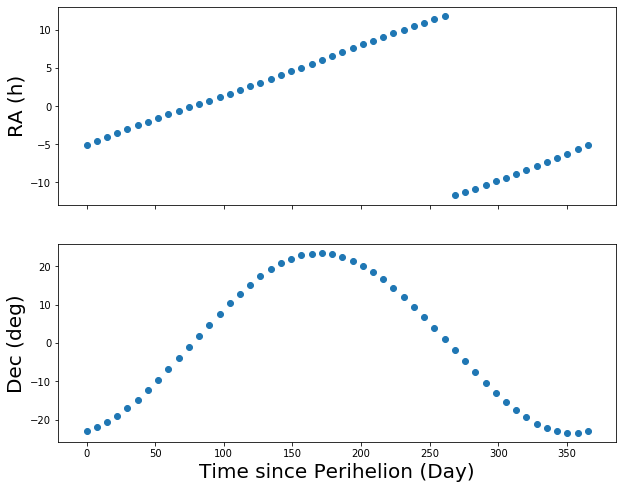

In [10]:
R2 = XE**2 + YE**2 + ZE**2
ras = np.arctan2(YE, XE) / np.pi * 12
decs = np.arcsin(ZE / np.sqrt(R2)) / np.pi * 180
f, ax = plt.subplots(2, 1, figsize=(10, 8), sharex='all')
ax[0].scatter(T_test, ras)
ax[1].scatter(T_test, decs)
ax[0].set_ylabel('RA (h)', fontsize=20)
ax[1].set_ylabel('Dec (deg)', fontsize=20)
ax[1].set_xlabel('Time since Perihelion (Day)', fontsize=20)

## 视差的计算

恒星在天球上的运动可以拆解为恒星相对于日地参考系 (坐标原点为日地质心，可以简化为太阳，坐标轴方向同赤道坐标系) 的自行和太阳在地球参考系中的周年视运动，后者已经可以表示为 $(x_E,y_E,z_E)(T)$，而前者在恒星到太阳距离为 $D$ 时表示为

$$
x_{hii,S}=D\cos \text{Dec}_S(T)\cos \text{RA}_S(T),\quad y_{hii,S}=D\cos \text{Dec}_S(T)\sin \text{RA}_S(T), \quad z_{hii,S}=D\sin \text{RA}_S(T)
$$

我们假设最简单的情形，即恒星的自行 $\mu_\alpha,\mu_\delta$ 都是常数，则有

$$
\text{Dec}_S(T) = \text{Dec}_S(T_P)+\mu_\delta\Delta T
$$

$$
\text{RA}_S(T) = \text{RA}_S(T_P)+\mu_\alpha^*\Delta T\quad (\mu_\alpha^*=\mu_\alpha\cos\text{Dec}_S(T)\approx \mu_\alpha\cos\text{Dec}_S(T_P))
$$

从而得到

$$
x_{hii}=D\cos \text{Dec}_S(T)\cos \text{RA}_S(T)+x_E(T),\quad y_{hii}=D\cos \text{Dec}_S(T)\sin \text{RA}_S(T)+y_E(T), \quad z_{hii}=D\sin \text{Dec}_S(T)+z_E(T)
$$

最终表示出我们的观测量

$$
\text{RA}(T) = \arctan\frac{y_{hii}}{x_{hii}}
$$

$$
\text{Dec}(T) = \arcsin{\frac{z_{hii}}{\sqrt{x_{hii}^2+y_{hii}^2+z_{hii}^2}}}
$$

In [11]:
raw = np.loadtxt('hii_625.txt')
t = raw[:, 0] * day
RA_h = raw[0, 1]
RA_m = raw[0, 2]
RA_s = raw[:, 3]
RAerr = raw[:, 4]
Dec_deg = raw[0, 5]
Dec_m = raw[0, 6]
Dec_s = raw[:, 7]
Decerr = raw[:, 8]
RAo = (RA_h + RA_m / 60 + RA_s / 3600) / 12 * np.pi # radian
Deco = (Dec_deg + Dec_m / 60 + Dec_s / 3600) / 180 * np.pi

In [12]:
def RA_Dec(theta, t):
    D, mua, mud, ras0, decs0 = theta
    mua *= arcsec / yr
    mud *= arcsec / yr
    ras0 *= radian
    decs0 *= radian
    D *= pc
    RAS = (ras0).in_cgs()
    DecS = (decs0).in_cgs()
    XE, YE, ZE = xyzE_t(t, T0=TP)
    XhS, YhS, ZhS = D * np.cos(DecS) * np.cos(RAS), D * np.cos(DecS) * np.sin(
        RAS), D * np.sin(DecS)
    Xh, Yh, Zh = XE + XhS, YE + YhS, ZE + ZhS
    RA = np.arctan2(Yh, Xh) + ((t - TP) * mua/radian).in_cgs()
    RA[RA < 0] += np.pi * 2
    Dec = np.arcsin(Zh / np.sqrt(Xh**2 + Yh**2 + Zh**2)) + ((t - TP) * mud/radian).in_cgs()
    return (RA, Dec)

## 拟合

对于 HII 625，我们有五个未知参数

- 太阳到 HII 625 的距离 $D$
- $T_P$ 时的坐标 $\text{RA}_S(T_P)$ 和 $\text{Dec}_S(T_P)$
- 相对于太阳的自行 $\mu_\alpha^*$ 和 $\mu_\delta$

我们使用 Monte Carlo Markov Chain (MCMC) 作参数估计。

### MCMC 拟合

MCMC 的核心思想是通过一种特殊的采样方式，使得最后样本在相空间内的分布可以体现模型的各种参数。具体地，我们先要设定参数的联合先验分布和给出的预测值满足的似然函数，在采样之后，样本在相空间内的分布会收敛到一个联合的后验分布，可以通过求取各个参数的边缘分布对参数进行估计。

#### 先验分布

不妨设各个参数都是独立的，且服从高斯分布。

- $D$：*Hipparcos* 给出 $\sim120$ pc，其他项目大多给出 $\sim135$ pc，这里我们考虑 $\mu=130$ pc，$\sigma=10$ pc。 

- $\text{RA}_S(T_P)$ 和 $\text{Dec}_S(T_P)$：利用第一个观测数据的坐标作为均值，同时估计自行的量级，发现约为数十个 mas/yr，则在大约 10 年的跨度上，变化不会超过一个角秒，因此取 $\sigma = 1$ arcsec。

In [13]:
# RA 上
(((RAo[1:]-RAo[0])/(t[1:]-t[0]))*rad).in_units('arcsec/yr')

YTArray([0.06165392, 0.05920451, 0.04897428, 0.0368834 , 0.02035875,
         0.02240292, 0.02746241]) arcsec/yr

In [14]:
# Dec 上
(((Deco[1:]-Deco[0])/(t[1:]-t[0]))*rad).in_units('arcsec/yr')

YTArray([-0.03832989, -0.03469657, -0.03671681, -0.03930148, -0.04441875,
         -0.04409169, -0.04307351]) arcsec/yr

- $\mu_\alpha^*$ 和 $\mu_\delta$：第一组数据和第七组数据前后观测时间恰好约为一年，取此时计算出的总自行作为自行先验分布的均值。根据上述结果，$\sigma$ 分别取为 5 mas/yr 和 1 mas/yr

#### 似然函数

先定义一个 $\chi^2$

$$
\chi^2=\sum_{i=1}^N\left[\frac{(\text{RA}_i-\text{RA}_{i,model})^2}{\sigma_{RA,i}^2}+\frac{(\text{Dec}_i-\text{Dec}_{i,model})^2}{\sigma_{Dec,i}^2}\right]
$$

这里的 $\sigma$ 取观测给出的误差，则似然函数

$$
\mathcal{L}=e^{-\chi^2/2}\Rightarrow \ln \mathcal{L}=-\frac{\chi^2}{2}
$$

对 $\mathcal{L}$ 最大化，相当于对 $\chi^2$ 最小化，也可以认为对残差进行了最小化。

In [36]:
import emcee


def log_likelihood(theta, t, RAo, Deco, RAerr, Decerr):
    D, mua, mud, ras0, decs0 = theta
    ndim = len(theta)
    RA, Dec = RA_Dec(theta, t=t)
    ratio = radian / arcsec
    dRA = (RAo - RA) * ratio  #from radian to arcsec
    dDec = (Deco - Dec) * ratio
    l = len(dRA)
    sigmaRA2 = RAerr**2 * (180 / 12)**2
    sigmaDec2 = Decerr**2
    return -0.5 * (dRA**2 / sigmaRA2 + dDec**2 / sigmaDec2).sum()


def log_prior(theta, normal=True):
    if normal:
        return -0.5 * np.sum((theta - theta0)**2 / theta_sigma**2 +
                             np.log(theta_sigma**2))
    else:
        for i in range(len(theta)):
            if (abs((theta - theta0)[i]) > theta_sigma[i]):
                return -np.inf
        return 0


def log_probability(theta, t, RAo, Deco, RAerr, Decerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, t, RAo, Deco, RAerr, Decerr)

In [16]:
theta0 = np.array([130, 0.0224, -0.0441, RAo[0], Deco[0]])
theta_sigma = np.array(
    [10, 5e-3, 1e-3, arcsec / radian, arcsec / radian])

pos = theta0 + theta_sigma * np.random.randn(10, 5) / 3
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers,
                                ndim,
                                log_probability,
                                args=(t, RAo, Deco, RAerr, Decerr),
                                moves=[
                                    (emcee.moves.DEMove(), 0.8),
                                    (emcee.moves.DESnookerMove(), 0.2),
                                ])
sampler.run_mcmc(pos, 300000, progress=True)

100%|██████████| 300000/300000 [3:42:28<00:00, 22.47it/s]  


State([[ 1.51566158e+02  2.07894097e-02 -4.48629859e-02  9.83288463e-01
   4.14122475e-01]
 [ 1.51571986e+02  2.07246917e-02 -4.47980068e-02  9.83288467e-01
   4.14122471e-01]
 [ 1.52117437e+02  2.08503149e-02 -4.47800159e-02  9.83288459e-01
   4.14122470e-01]
 [ 1.52072793e+02  2.08209923e-02 -4.47186353e-02  9.83288461e-01
   4.14122466e-01]
 [ 1.51842869e+02  2.07906659e-02 -4.48073413e-02  9.83288463e-01
   4.14122472e-01]
 [ 1.51907057e+02  2.07935801e-02 -4.49637481e-02  9.83288463e-01
   4.14122481e-01]
 [ 1.51953710e+02  2.07433885e-02 -4.47231621e-02  9.83288466e-01
   4.14122466e-01]
 [ 1.51866266e+02  2.07951639e-02 -4.48057549e-02  9.83288463e-01
   4.14122471e-01]
 [ 1.51420824e+02  2.07076904e-02 -4.46749296e-02  9.83288468e-01
   4.14122463e-01]
 [ 1.51509284e+02  2.08087319e-02 -4.48891858e-02  9.83288462e-01
   4.14122477e-01]], log_prob=[-506.76607364 -506.36083559 -506.54603839 -506.49116764 -506.19786746
 -508.39771274 -506.41710783 -506.21359815 -506.41154263 -507.

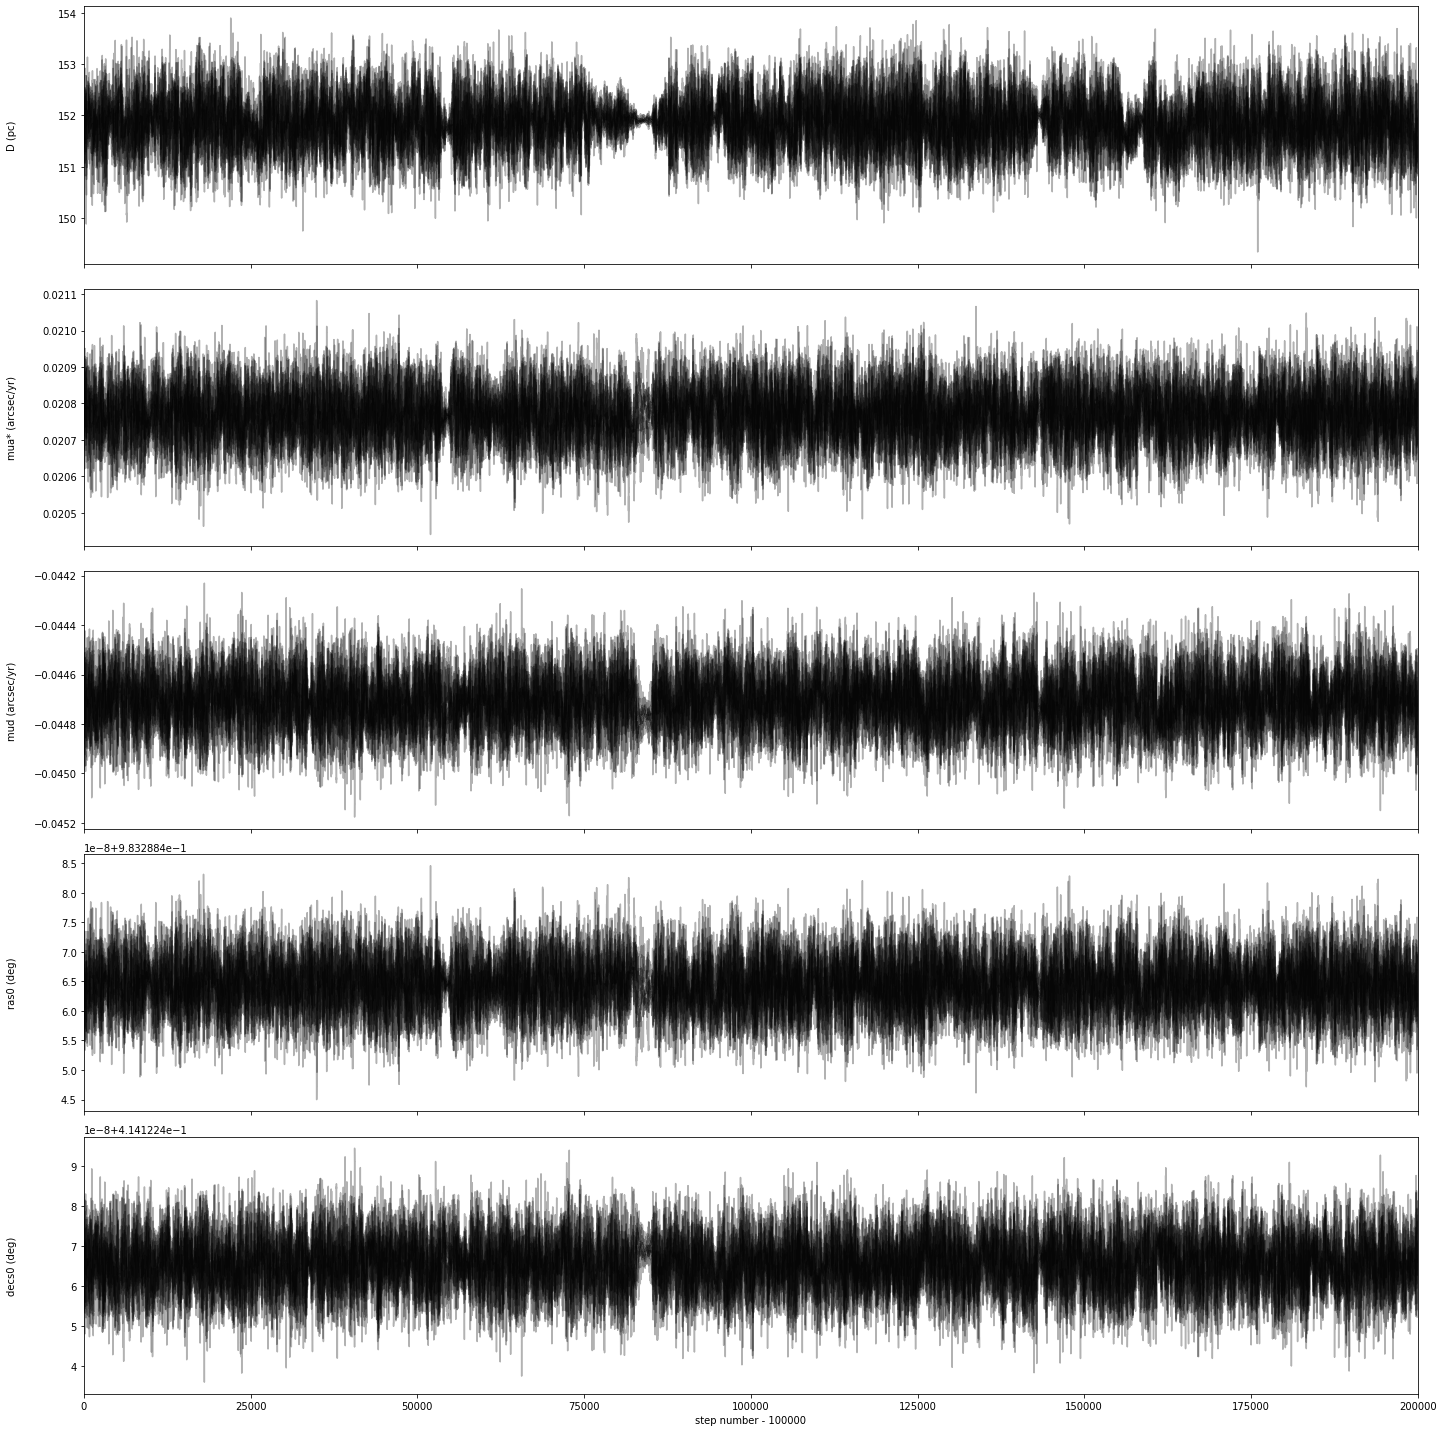

In [25]:
fig, axes = plt.subplots(5, figsize=(20, 20), sharex=True)
samples = sampler.get_chain()
labels = ["D (pc)", "mua* (arcsec/yr)", "mud (arcsec/yr)", "ras0 (deg)", "decs0 (deg)"]
Nburn = 100000
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[Nburn:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples) - Nburn)
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.05, 0.5)

if not Nburn:
    axes[-1].set_xlabel("step number")
else:
    axes[-1].set_xlabel("step number - {}".format(Nburn))
fig.tight_layout()

在选定的 50000 步模拟中，burn-in 过程占了相当长的时间，这暗示在现有的时间/计算资源的条件下，MCMC 采样可能并没有收敛到准确值。我们取 10000 步以后的结果绘制边缘分布图：

(99930, 5)


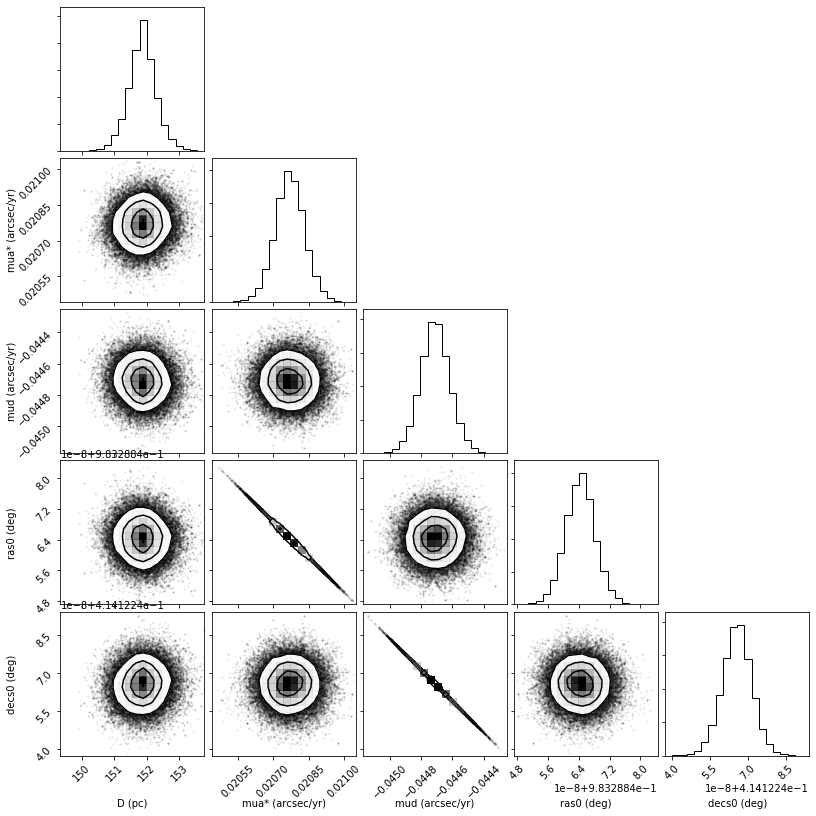

In [28]:
import corner

flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
flat_samples = flat_samples[Nburn:, ]
print(flat_samples.shape)

fig = corner.corner(flat_samples, labels=labels)

据此可以利用后验分布估计我们需要的几个物理量和相应的 $\chi^2$，并作图对比模型和观测数据。

In [29]:
from IPython.display import display, Math

#Distance
mcmc = np.percentile(flat_samples[:, 0], [16, 50, 84])
q = np.diff(mcmc)
txt = "\mathrm{{{3}}} = {0:.1f}_{{-{1:.1f}}}^{{{2:.1f}}}"
txt = txt.format(mcmc[1], q[0], q[1], labels[0])
display(Math(txt))

#Proper motion
for i in [1,2]:
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.4f}_{{-{1:.4f}}}^{{{2:.4f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))
    
theta_fit = np.array([])
for i in range(ndim):
    theta_fit = np.append(theta_fit, np.percentile(flat_samples[:, i], [50]))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [37]:
ll = log_likelihood(theta_fit, t, RAo, Deco, RAerr, Decerr)
chi2 = -2*ll
chi2

1074.5777235980795 dimensionless

### RA v.s. Dec

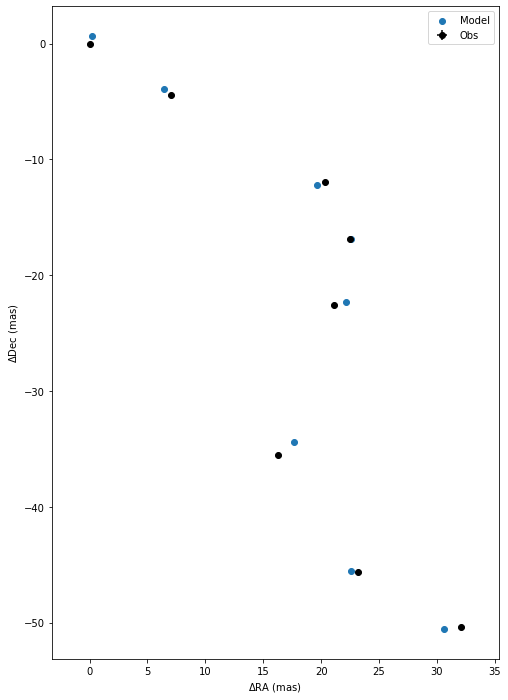

In [31]:
theta = np.array([])
for i in range(ndim):
    theta = np.append(theta, np.percentile(flat_samples[:, i], 50))
D_fit, mua_fit, mud_fit, ra0_fit, dec0_fit = theta
RA, Dec = RA_Dec(theta, t=t)

plt.figure(figsize=(8, 12))
plt.scatter((RA - RAo[0]) * radian / arcsec * 1000,
            (Dec - Deco[0]) * radian / arcsec * 1000,
            label='Model')
plt.errorbar((RAo - RAo[0]) * radian / arcsec * 1000,
             (Deco - Deco[0]) * radian / arcsec * 1000,
             xerr=(180 / 12) * RAerr,
             yerr=Decerr,
             fmt='o',
             color='k',
             label="Obs")
plt.xlabel(r'$\Delta$RA (mas)')
plt.ylabel(r'$\Delta$Dec (mas)')
plt.axis('equal')
plt.legend()
plt.show()

### 扣去自行后的赤经/赤纬变化

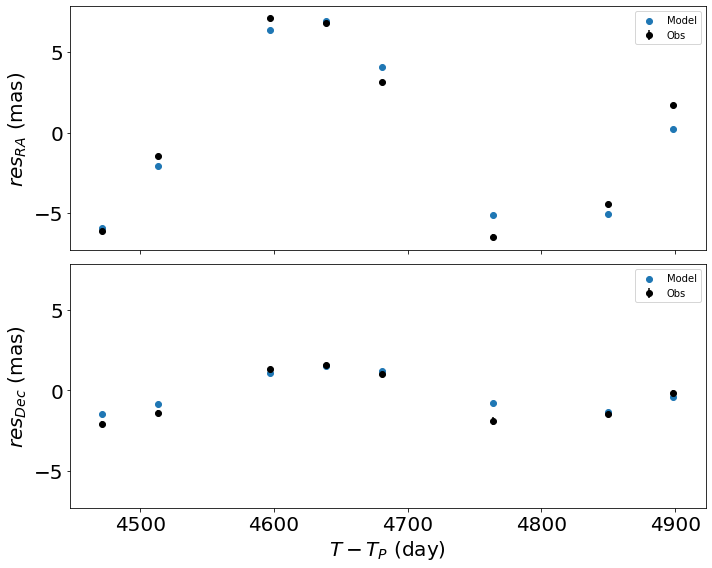

In [32]:
f, ax = plt.subplots(2, 1, figsize=(10, 8), sharex='all', sharey='all')
ax[0].scatter(t - TP,
              (RA - mua_fit / yr *
               (t - TP) / 3600 * np.pi / 180 - ra0_fit) * 1000 * radian /
              arcsec,
              label='Model')
ax[1].scatter(t - TP,
              (Dec - mud_fit / yr * (t - TP) / 3600 * np.pi / 180 - dec0_fit) *
              1000 * radian / arcsec,
              label='Model')
ax[0].errorbar(t - TP,
               (RAo - mua_fit / yr *
                (t - TP) / 3600 * np.pi / 180 - ra0_fit) * 1000 * radian /
               arcsec,
               yerr=RAerr * 1000 * (180 / 12),
               label='Obs', fmt='o', color='k')
ax[1].errorbar(t - TP, (Deco - mud_fit / yr *
                        (t - TP) / 3600 * np.pi / 180 - dec0_fit) * 1000 *
               radian / arcsec,
               yerr=Decerr * 1000,
               label='Obs', fmt='o', color='k')
ax[1].set_xlabel(r'$T-T_P$ (day)', fontsize=20)
ax[0].set_ylabel(r'$res_{RA}$ (mas)', fontsize=20)
ax[1].set_ylabel(r'$res_{Dec}$ (mas)', fontsize=20)
ax[0].tick_params(labelsize=20)
ax[1].tick_params(labelsize=20)
f.tight_layout()
ax[0].legend()
ax[1].legend()

### 残差图

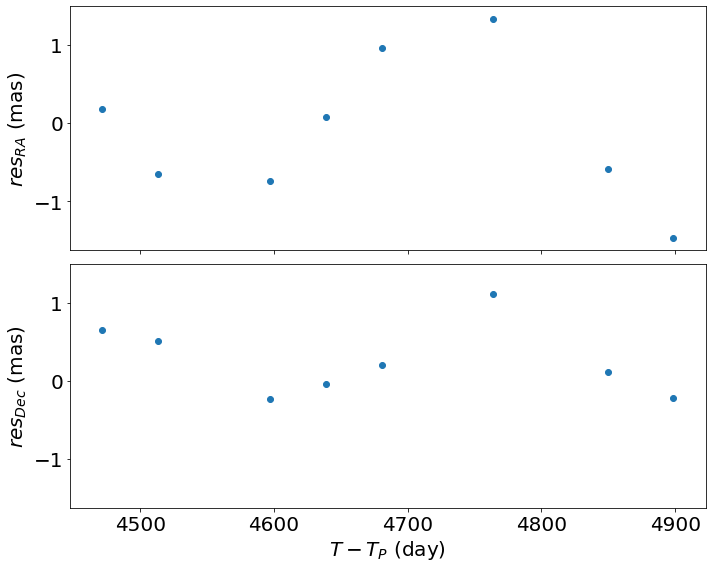

In [33]:
f, ax = plt.subplots(2, 1, figsize=(10, 8), sharex='all', sharey='all')
ax[0].scatter(t - TP, (RA - RAo)*1000*radian/arcsec)
ax[1].scatter(t - TP, (Dec - Deco)*1000*radian/arcsec)
ax[1].set_xlabel(r'$T-T_P$ (day)', fontsize=20)
ax[0].set_ylabel(r'$res_{RA}$ (mas)', fontsize=20)
ax[1].set_ylabel(r'$res_{Dec}$ (mas)', fontsize=20)
ax[0].tick_params(labelsize=20)
ax[1].tick_params(labelsize=20)
f.tight_layout()

从 $\chi^2$ 和上图中可以看到拟合后的残差依然很显著，MCMC 采样可能没有收敛到最终的值，但由于时间和计算资源限制，无法进行更多的计算。

## 讨论：自行加速度

原则上我们可以再假定两个恒定的加速度 $a_\alpha^*$ 和 $a_\delta$，重新进行拟合。问题在于我们一共只有 $8$ 个数据点，而模型中已经有 $5$ 个自由参数，若再加入 $a_\alpha^*$ 和 $a_\delta$ 很容易发生过拟合，因此我们不考虑含有自行加速度的模型。